# MONOCAMCCDRed a package to do CCD reduction for MONOCAM/LSST
===============================================================================================================

This is the notebook to do the whole CCD reduction pipeline using the **CCDPROC** python package from astropy astronomical tools.
We are considering raw data images that comes from fits file which header does not full conform to standard.
Some keywords are missing.

- Creation date : Friday 2016 June 3rd
- Update : Satuday 2016 June 4th
- Author Sylvie Dagoret-Campagne (SDC adapted for LSST from Matt Craig's example notebook)
- affiliation : LAL/IN2P3/CNRS

This notebook is inspired and adapted from the Matt Craig notebook available here
http://nbviewer.jupyter.org/gist/mwcraig/06060d789cc298bbb08e

## 1.) Required softwares

Please make sure you have this software installed before you begin (in addition to the usual scipy, numpy):

+ [astropy](http://astropy.org) v 0.4 or higher (install with: ``pip install astropy`` in a terminal/command window)
+ [ccdproc](http://ccdproc.readthedocs.org) v 0.1.1 or higher (install with: ``pip install ccdproc`` in a terminal/command window)
+ [msumastro](http://msumastro.readthedocs.org) v 0.5 or higher (install with : ``pip install msumastro`` in a terminal/command window)

## 2.) Main Packages imports

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [98]:
from scipy import stats  
import os
from datetime import datetime, timedelta

In [99]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [100]:
from msumastro import ImageFileCollection, TableTree
# I know you can't do correlated errors....
nddata.conf.warn_unsupported_correlated = False

In [101]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-04 09:49:39.378181
fits date format for the analysis :  2016-06-04T09:49:39


## 3) Set some properties of the instrument that took these images

- MONOCAM, one of the 200 CCD plate of LSST camera.
- This CCD is 4Kx4K readout by 16 amplifiers

Eeach fits file contains a primary header plus the 16 images

- 16 images of size 544 x 2048 pixels
corresponding of :
- 8 columns of 544 pixels : 8 x 544 = 4352 pixels 
- 2 raws of 2048 pixels : 2 x 2048 = 4096 pixels

There is an excess of 4352-4096= 256 pixels along the columns.
It is possible there is 32 overscan slots.


A pre-look to the flats data using ds9 or python script allowed me to guess what are the Trim section and the Bias section

In [102]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

# 4. Define a few convenience functions

All of these are really optional, but some are pretty convenient. They are provided in part to illustrate how one can combine the basic ``ccdproc`` commands into something more like a pipeline.

## a. Subtract overscan and trim images in a list

I have checked that substracting overscan region reduce very significantly the width of the pedestals (biases) distribution.
Obviously it is necessary to apply this pre-correction image by image.

(SDC)

In [103]:
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img,overscan=img[:,521:544], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:,10:521], add_keyword={'trimmed': True, 'calstat': 'OT'})

## b. Calculate fast medians (only really needed until numpy 1.9)

###     A bottleneck-based replacement for ma.median for a *single* array

As explained above, in numpy 1.8.1 and lower the masked median of a stack of images is very slow.

In [104]:
def bn_median(masked_array, axis=None):
    """
    Perform fast median on masked array
    
    Parameters
    ----------
    
    masked_array : `numpy.ma.masked_array`
        Array of which to find the median.
    
    axis : int, optional
        Axis along which to perform the median. Default is to find the median of
        the flattened array.
    """
    data = masked_array.filled(fill_value=np.NaN)
    med = bn.nanmedian(data, axis=axis)
    # construct a masked array result, setting the mask from any NaN entries
    return np.ma.array(med, mask=np.isnan(med))

### A bottleneck-based replacement for a stack (i.e. list) of masked arrays

By "stack" I mean a group of images, e.g. darks of the same exposure, for which the appropriate baseline image for identifying bad pixels is a median image (rather than a median or mean of the whole stack)

In [105]:
def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)

### A little function for displaying image statistics....

..which is useful for determining scale when displaying an image.

In [106]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

### To make the list of biases

In [107]:
def BuildFilelist(path,name,ext='.fits',start=1,stop=99):
    '''
    Make the list of filenames required by ccdproc
    
    input:
       path : path of files
       name : common root of bias filenames
       ext  : extension of filenames
       start,stop : indexes of files
    output:
       full filename list
    '''
    filelist = []
    for num in range(start,stop+1,1):
        strnum=biasnumberstr= '{0:02d}'.format(num)  # python >= 2.6
        filename=name+strnum+ext
        fullfilename=os.path.join(path,filename)
        filelist.append(fullfilename)
    return filelist

## 5.) Read data

In [108]:
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
ext_filename='.fits'

### 5.1) The biases

In [109]:
root_biasfilename='bias_'
bias_startnum=1
bias_stopnum=50

In [110]:
rawbias_list=BuildFilelist(path,root_biasfilename,start=bias_startnum,stop=bias_stopnum)

In [111]:
NB_OF_BIAS=len(rawbias_list)

### a. First, load the data as a list of ``CCDData`` objects.

If you don't need to modify the metadata you could use ``ccdproc.CCDData.from_hdu(hdu)`` to create the ``CCDData`` object.

In [112]:
allrawbias = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in rawbias_list ]
    allrawbias.append(ccd_chan)

### b. Subtract overscan and trim using convenience function

In [113]:
for chan in range(NB_OF_CHAN_AMPL):
    oscan_and_trim(allrawbias[chan])

### c. Combine biases using average

In [114]:
masterbias_list=[]
for chan in range(NB_OF_CHAN_AMPL):
    biases = ccdproc.Combiner(allrawbias[chan])
    #master_bias = biases.average_combine() # assymetric pedestals ==>  Not good at all
    master_bias = biases.median_combine()  # median gives much more symetric gaussian distributed pedestals
    masterbias_list.append(master_bias)

### d. Make a pretty picture...

Because why wouldn't you?

In [115]:
print 'channel bias_min, bias_max, bias_mean, bias_std'
for chan in range(NB_OF_CHAN_AMPL):
    bias_min, bias_max, bias_mean, bias_std = imstats(np.asarray(masterbias_list[chan]))
    print chan+1,bias_min, bias_max, bias_mean, bias_std
    
    #plt.figure(figsize=(5, 5))
    #plt.imshow(masterbias_list[chan], vmax=bias_mean + 4*bias_std, vmin=bias_mean - 4*bias_std)

channel bias_min, bias_max, bias_mean, bias_std
1 -0.952487032942 2.22890796464 0.52412098655 0.405690252309
2 -1.16875017384 3.21116672131 0.835123553886 0.436710278374
3 -1.35943785773 2.29913690471 0.582151819577 0.351282220076
4 -1.24801607268 2.13536082393 0.440461607753 0.396602242374
5 -1.61020449616 2.17614686044 0.417946907554 0.391433684322
6 -1.33269092516 2.17256144019 0.367089552783 0.403332187422
7 -1.21058082508 2.19168533557 0.53106740456 0.41577432511
8 -1.22059267322 50.8024038395 0.510564206495 0.393219514833
9 -1.44845854848 2.81475592924 0.570777070836 0.459631714664
10 -1.53580903815 2.43070151847 0.318736565129 0.452002107085
11 -1.60428125253 2.62629346877 0.413533285763 0.439983250228
12 -1.37842289011 3.1952920956 0.594821859163 0.485783669881
13 -1.73322875247 75.2487472038 0.336126402241 0.460764436441
14 -1.44021325225 75.0087383352 0.726649707 0.452902587068
15 -3.05358885328 32.1086303781 0.64348879772 0.798061738472
16 -1.45196405145 161.102574031 0.5510

In [116]:
def ShowImagesSet(masterbiaslist):
    '''
    Shows the whole set of CCD images
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
     
    NX=8 # number of images along the horizontal axis
    NY=2 # number of images along the vertical axis
    BIASMIN=-4.0
    BIASMAX=4.0
    f, axarr = plt.subplots(NY,NX,sharex='col', sharey='row',figsize=(15,15)) # figure organisation
    
    f.subplots_adjust(hspace=0.05,wspace=0.05)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%8
        iy=index/8
        image_data = masterbiaslist[index].data
        im=axarr[iy,ix].imshow(image_data,vmin=BIASMIN,vmax=BIASMAX)  # plot the image
        
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_title(plottitle)
    
    title='Master Biases'
    #plt.colorbar(orientation='horizontal')
    plt.suptitle(title,size=16)

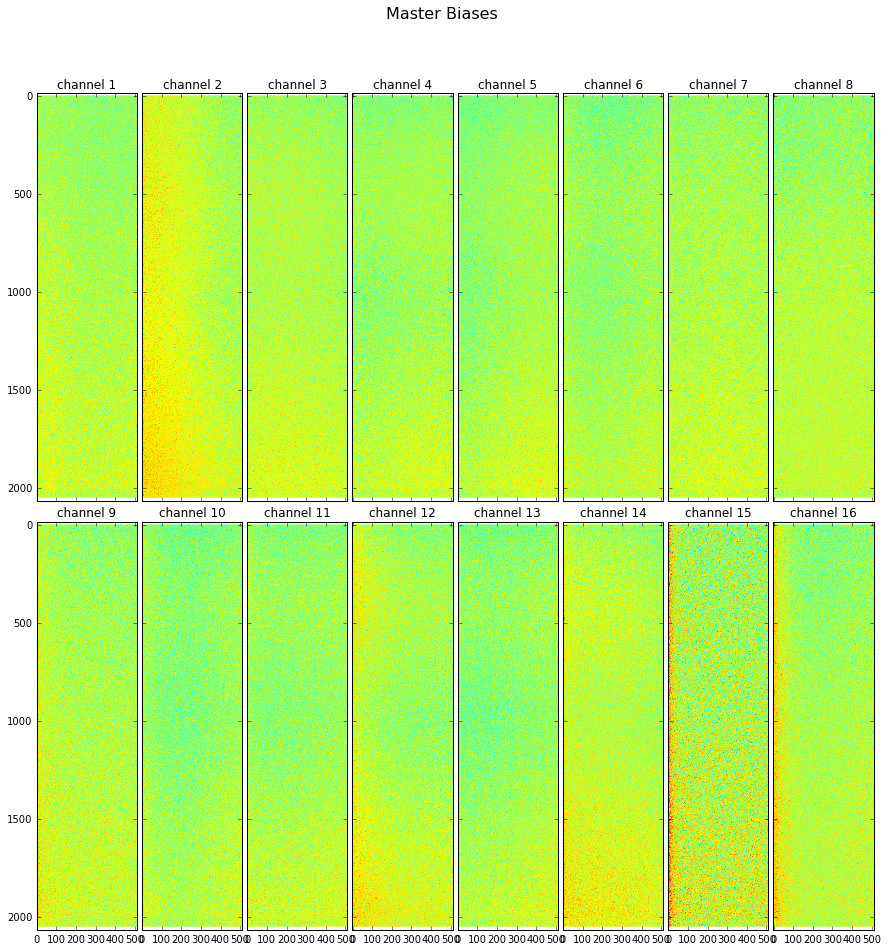

In [117]:
ShowImagesSet(masterbias_list)

In [118]:
def ShowHistoSet(masterbiaslist):
    '''
    Shows the whole set of CCD histograms
     - inputs argument:
       path : path of the fits file
       filename of the fits file
     - output the images of the whole CCD   
    '''
   
    
    NX=4 # number of images along the horizontal axis
    NY=4 # number of images along the vertical axis
    BIASMIN=-10.0
    BIASMAX=10.0
    BINWIDTH=1
    f, axarr = plt.subplots(NY,NX,figsize=(20,20)) # figure organisation
    #f, axarr = plt.subplots(NX,NY,sharex=True, sharey=True,figsize=(20,20))
    f.subplots_adjust(hspace=0.5,wspace=0.5)

    for index in range(NB_OF_CHAN_AMPL):  
        ix=index%4
        iy=index/4
        image_data = image_data = masterbiaslist[index].data
        data=image_data.flatten()
        axarr[iy,ix].hist(data,bins=np.arange(min(data), max(data) + BINWIDTH, BINWIDTH),facecolor='blue', alpha=0.75,log=True)  # plot the image
        plottitle='channel {}'.format(index+1)
        axarr[iy,ix].set_xlim(BIASMIN,BIASMAX)
        axarr[iy,ix].set_title(plottitle)
        axarr[iy,ix].set_xlabel('ADU')
        axarr[iy,ix].grid(True)
        #axarr[iy,ix].set_yscale('log')

    plt.yscale('log')
    title='Master Bias for combined biases with median substraction'
    plt.suptitle(title,size=16)

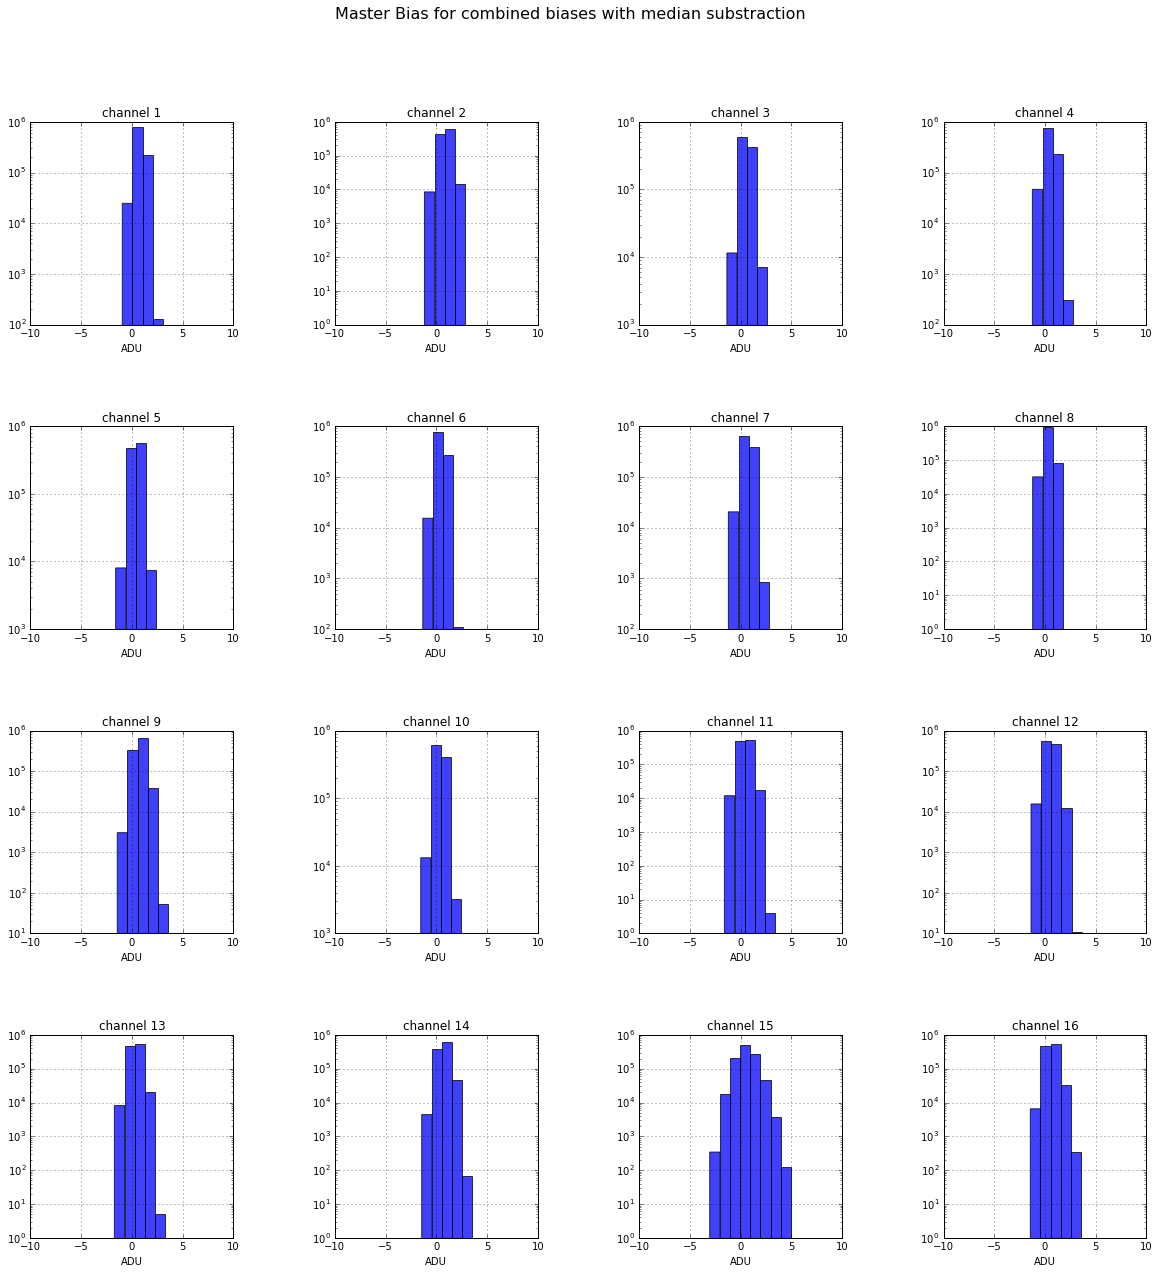

In [119]:
ShowHistoSet(masterbias_list)

### 5.2) The darks

In [120]:
root_darkfilename='dark_'
dark_startnum=1
dark_stopnum=63

In [ ]:
rawdark_list=BuildFilelist(path,root_darkfilename,start=dark_startnum,stop=dark_stopnum)

In [ ]:
allrawdark = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = [ ccdproc.CCDData.read(image_file, hdu=chan,unit="adu") for image_file in rawdark_list ]
    allrawdark.append(ccd_chan)


### 5.3) The sky flats